# Dependencias

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from varclushi import VarClusHi
from scipy import stats

from datetime import datetime,date

import os

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [2]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/Chicago_incidents/'
archivos = sorted([os.path.join(ruta,arch) for arch in os.listdir(ruta)])
archivos

['/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/Chicago_incidents/Chicago_Crimes_2001_to_2004.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/Chicago_incidents/Chicago_Crimes_2005_to_2007.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/Chicago_incidents/Chicago_Crimes_2008_to_2011.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/Chicago_incidents/Chicago_Crimes_2012_to_2017.csv']

In [3]:
df = pd.concat(map(lambda v:pd.read_csv(v,on_bad_lines='skip', low_memory=False).sample(250),archivos), ignore_index=True)
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4445942,2369060,HH672428,09/25/2002 08:00:00 PM,008XX W WINDSOR AVE,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,2313,19.0,46.0,3.0,04A,1169767.0,1930393.0,2002.0,04/15/2016 08:55:02 AM,41.964502363,-87.651196,"(41.964502363, -87.651196391)"
1,4770361,2774063,HJ421392,06/10/2003 06:30:00 PM,072XX S SOUTH CHICAGO AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,323,3.0,5.0,69.0,26,1183429.0,1857513.0,2003.0,04/15/2016 08:55:02 AM,41.764206589,-87.603244,"(41.764206589, -87.603244488)"
2,3898725,1762273,G574428,09/24/2001 04:00:00 PM,066XX S CHAMPLAIN AV,0920,MOTOR VEHICLE THEFT,ATT: AUTOMOBILE,STREET,False,False,321,3.0,NaN,NaN,07,1181664.0,1861257.0,2001.0,08/17/2015 03:03:40 PM,41.774521425,-87.609598,"(41.774521425, -87.609598108)"
3,4564005,2516833,HH862944,11/01/2002 12:00:00 AM,015XX N KARLOV AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,True,True,2534,25.0,30.0,23.0,20,1148765.0,1910014.0,2002.0,04/15/2016 08:55:02 AM,41.909013488,-87.728944,"(41.909013488, -87.728943547)"
4,3628536,1421887,G137521,03/10/2001 02:10:00 AM,002XX E GARFIELD BV,0460,BATTERY,SIMPLE,APARTMENT,False,True,232,2.0,NaN,NaN,08B,1178804.0,1868640.0,2001.0,08/17/2015 03:03:40 PM,41.794846672,-87.619858,"(41.794846672, -87.619857722)"


In [4]:
df.shape

(1000, 23)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    1000 non-null   int64  
 1   Case Number           1000 non-null   object 
 2   Date                  1000 non-null   object 
 3   Block                 1000 non-null   object 
 4   IUCR                  1000 non-null   object 
 5   Primary Type          1000 non-null   object 
 6   Description           1000 non-null   object 
 7   Location Description  999 non-null    object 
 8   Arrest                1000 non-null   bool   
 9   Domestic              1000 non-null   bool   
 10  Beat                  1000 non-null   int64  
 11  District              1000 non-null   float64
 12  Ward                  919 non-null    float64
 13  Community Area        919 non-null    float64
 14  FBI Code              1000 non-null   object 
 15  X Coordinate          

# Definición de variables

In [6]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [41]:
um = ['ID']
vart1 = ['Latitude']
vart2 = ['Longitude']
varc = [v for v in df.columns if v not in um and v not in vart1 and v not in vart2
                            and (df[v].dtype=='float64' or df[v].dtype=='int64') and v!='X Coordinate'
                            and v!='Y Coordinate']
vard = [v for v in df.columns if v not in um and v not in vart1 and v not in vart2 and v not in varc
       and v!='Location' and (df[v].dtype=='object' or df[v].dtype=='bool') and v!='Updated On' and v!='Y Coordinate' and v!='Date']

# Análisis exploratorio

## Variables continuas

### Valores nulos

In [44]:
nulos = 1-df[varc].describe().T[['count']]/len(df)
nulos

,count
Beat,0.000
District,0.000
Ward,0.081
Community Area,0.081
Year,0.000


In [45]:
imp = SimpleImputer(strategy='median')
imp.fit(df[varc])

SimpleImputer(strategy='median')

In [48]:
X = pd.DataFrame(imp.transform(df[varc]),columns=varc)
X[um+vart1+vart2] = df[um+vart1+vart2]

In [63]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(X[v],df[v].dropna()).statistic),varc),
                  columns=['var','ks']).set_index('var').sort_values(by='ks',ascending=False)
ks

,ks
var,
Ward,0.040368
Community Area,0.040103
Beat,0.000000
District,0.000000
Year,0.000000


In [66]:
varc = [v for v in ks.index if ks['ks'][v]<0.05]
varc

['Ward', 'Community Area', 'Beat', 'District', 'Year']

### Varianza nula

In [67]:
vt = VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [70]:
fuera = [a for a,b in zip(varc,vt.get_support())if not b]
fuera

[]

## Variables discretas

In [94]:
Xi = df[vard].copy()

In [95]:
for v in vard:
    for a,b in zip(list(Xi[v].dropna().unique()),range(1,len(list(Xi[v].dropna().unique()))+1)):
        Xi.loc[Xi[v]==a,v]=b
    Xi[v] = pd.to_numeric(Xi[v],errors='coerce')

### Valores nulos

In [96]:
nulos = 1-Xi[vard].describe().T[['count']]/len(df)
nulos

,count
Case Number,0.000
Block,0.000
IUCR,0.000
Primary Type,0.000
Description,0.000
Location Description,0.001
Arrest,0.000
Domestic,0.000
FBI Code,0.000


In [97]:
imp.fit(Xi[vard])

SimpleImputer(strategy='median')

In [98]:
Xii = pd.DataFrame(imp.transform(Xi[vard]),columns=vard)
Xii[um+vart1+vart2] = df[um+vart1+vart2]

In [99]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xii[v],Xi[v].dropna()).statistic),vard),
                  columns=['var','ks']).set_index('var').sort_values(by='ks',ascending=False)
ks

,ks
var,
Location Description,0.000461
Case Number,0.000000
Block,0.000000
IUCR,0.000000
Primary Type,0.000000
Description,0.000000
Arrest,0.000000
Domestic,0.000000
FBI Code,0.000000


In [122]:
vard = [v for v in ks.index if ks['ks'][v]<0.05]
vard

['Location Description',
 'Case Number',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Arrest',
 'Domestic',
 'FBI Code']

### Varianza nula

In [123]:
vt.fit(Xii[vard])

VarianceThreshold()

In [124]:
fuera = [a for a,b in zip(vard,vt.get_support())if not b]
fuera

[]

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [137]:
S = X.merge(Xii[um+vard],on=um,how='inner')

In [138]:
sc = MinMaxScaler()
sc.fit(S[varc+vard])

MinMaxScaler()

In [140]:
X01 = pd.DataFrame(sc.transform(S[varc+vard]),columns=varc+vard)
X01[um+vart1+vart2] = S[um+vart1+vart2]

In [153]:
X01.dropna(inplace=True)

## Multicolinealidad

vc = VarClusHi(X01,feat_list=varc+vard).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

## Selección de variables con mejor poder predictivo

In [164]:
X01[vart1[0]] = pd.to_numeric(X01[vart1[0]])

In [174]:
sk1 = SelectKBest(k=len(varc+vard),score_func=f_regression)
sk1.fit(X01[varc+vard],X01[vart1[0]])

SelectKBest(k=14, score_func=<function f_regression at 0x7f5ff32595a0>)

In [175]:
sk2 = SelectKBest(k=len(varc+vard),score_func=f_regression)
sk2.fit(X01[varc+vard],X01[vart2[0]])

SelectKBest(k=14, score_func=<function f_regression at 0x7f5ff32595a0>)

In [176]:
pd.DataFrame(zip(varc+vard,sk1.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                ascending=False).iplot(kind='bar',color='orange')

In [177]:
pd.DataFrame(zip(varc+vard,sk2.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                ascending=False).iplot(kind='bar',color='orange')

In [178]:
sk = SelectKBest(k=4,score_func=f_regression)
sk.fit(X01[varc+vard],X01[vart1[0]])

SelectKBest(k=4, score_func=<function f_regression at 0x7f5ff32595a0>)

In [179]:
best = [a for a,b in zip(varc+vard,sk.get_support())if b]
best

['Ward', 'Community Area', 'Beat', 'District']

## Valores extremos

array([[<AxesSubplot:title={'center':'Ward'}>,
        <AxesSubplot:title={'center':'Community Area'}>],
       [<AxesSubplot:title={'center':'Beat'}>,
        <AxesSubplot:title={'center':'District'}>]], dtype=object)

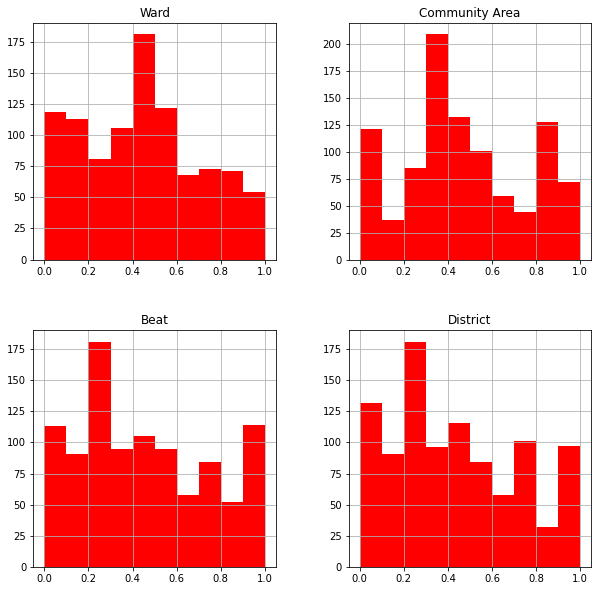

In [180]:
X01[best].hist(figsize=(10,10),color='red')

In [181]:
for v,li,ls in X01[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X01[f'ex_{v}'] = ((X01[v]<li)|(X01[v]>ls)).astype(int)
X01['ex_'] = X01.filter(like='ex_').max(axis=1)
X01['ex_'].value_counts(1)

0    0.968623
1    0.031377
Name: ex_, dtype: float64

In [185]:
X01 = X01.loc[X01['ex_']==0].drop(X01.filter(like='ex_').columns,axis=1)

array([[<AxesSubplot:title={'center':'Ward'}>,
        <AxesSubplot:title={'center':'Community Area'}>],
       [<AxesSubplot:title={'center':'Beat'}>,
        <AxesSubplot:title={'center':'District'}>]], dtype=object)

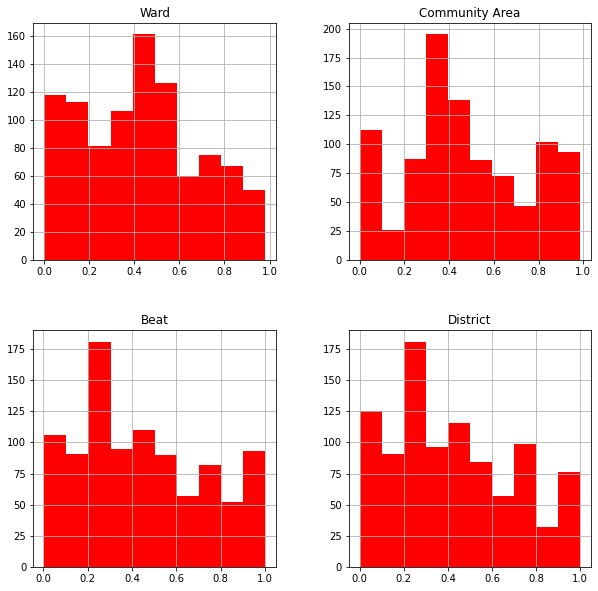

In [187]:
X01[best].hist(figsize=(10,10),color='red')

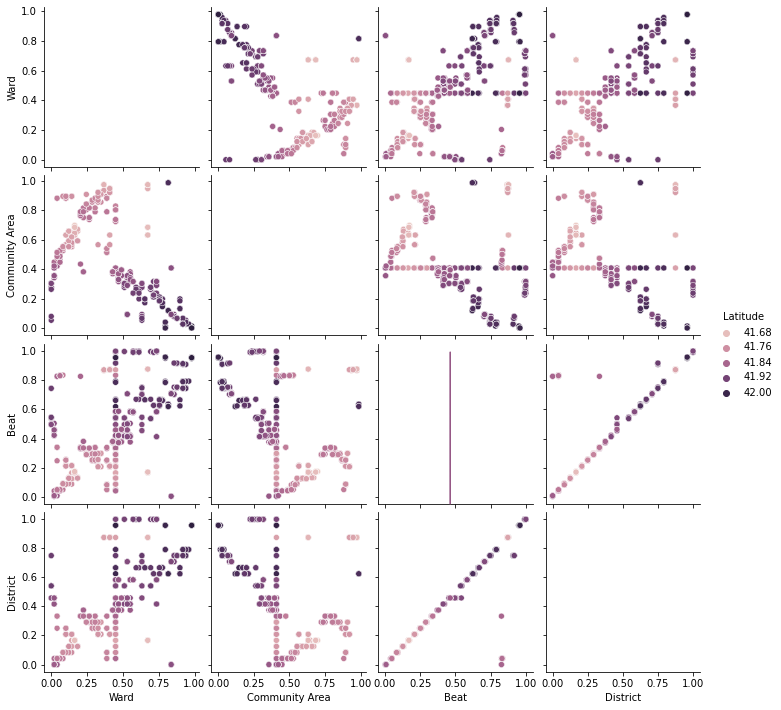

In [188]:
sns.pairplot(data=X01[best+vart1],hue=vart1[0])

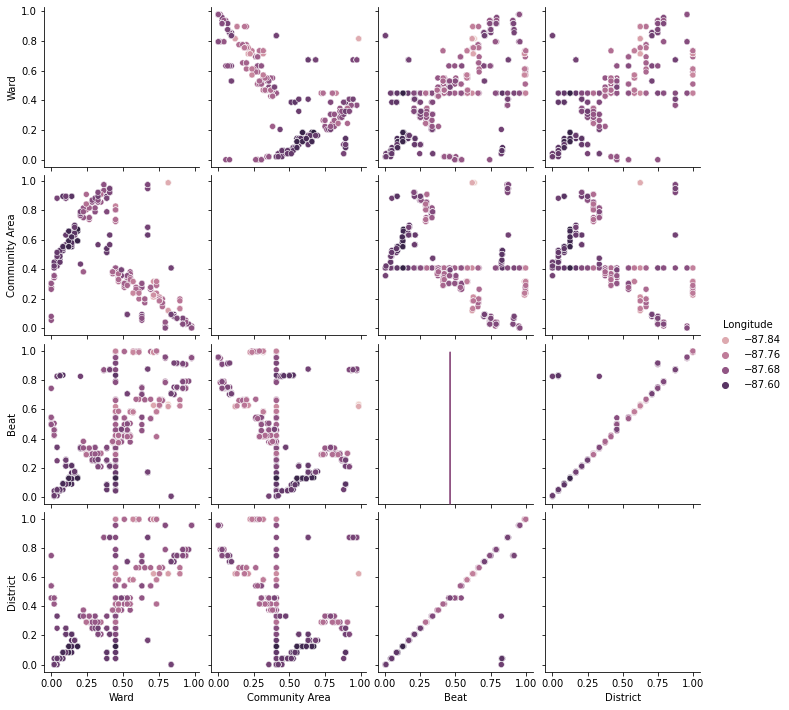

In [189]:
sns.pairplot(data=X01[best+vart2],hue=vart2[0])

# Partición de entrenamiento

In [216]:
Sn,St = train_test_split(X01[um+best+vart1+vart2],train_size=0.7)
Sn.reset_index(drop=True,inplace=True)
St.reset_index(drop=True,inplace=True)

# Aprendizaje

## Latitud

### LR

In [253]:
modelo = LinearRegression(n_jobs=-1)
modelo.fit(X01[best],X01[vart1[0]])

LinearRegression(n_jobs=-1)

#### Validación

In [254]:
Sn['Latitude^'] = modelo.predict(Sn[best])
St['Latitude^'] = modelo.predict(St[best])

In [255]:
print(mean_absolute_error(y_pred=Sn['Latitude^'],y_true=Sn[vart1[0]]))
print(mean_absolute_error(y_pred=St['Latitude^'],y_true=St[vart1[0]]))

0.0333952708244454
0.03161980335277824


In [256]:
print(r2_score(y_pred=Sn['Latitude^'],y_true=Sn[vart1[0]]))
print(r2_score(y_pred=St['Latitude^'],y_true=St[vart1[0]]))

0.7030662852264997
0.7227935958567424


<AxesSubplot:ylabel='Density'>

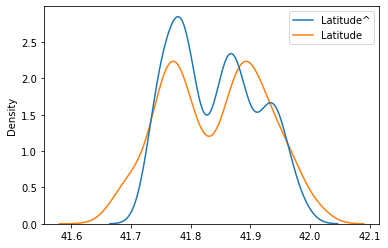

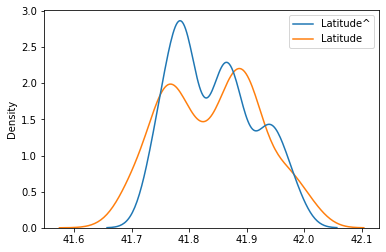

In [257]:
plt.figure()
sns.kdeplot(data=Sn[['Latitude^']+vart1])
plt.figure()
sns.kdeplot(data=St[['Latitude^']+vart1])

### RC

In [233]:
hp=dict(alpha=np.arange(0.1,3,0.1))
modelo = Ridge()
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [234]:
grid.fit(Sn[best],Sn[vart1[0]])

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [235]:
grid.best_params_

{'alpha': 2.9000000000000004}

In [236]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=2.9000000000000004)

In [237]:
modelo.fit(Sn[best],Sn[vart1[0]])

Ridge(alpha=2.9000000000000004)

#### Validación

In [238]:
Sn['Latitude^'] = modelo.predict(Sn[best])
St['Latitude^'] = modelo.predict(St[best])

In [239]:
print(mean_absolute_error(y_pred=Sn['Latitude^'],y_true=Sn[vart1[0]]))
print(mean_absolute_error(y_pred=St['Latitude^'],y_true=St[vart1[0]]))

0.03299179489647566
0.03139140632422174


In [240]:
print(r2_score(y_pred=Sn['Latitude^'],y_true=Sn[vart1[0]]))
print(r2_score(y_pred=St['Latitude^'],y_true=St[vart1[0]]))

0.7019838266915953
0.7212362423226026


<AxesSubplot:ylabel='Density'>

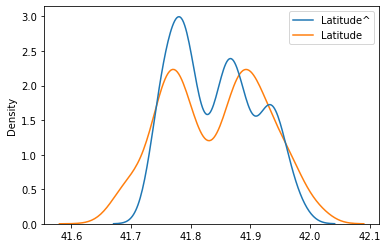

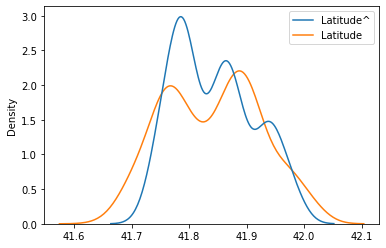

In [241]:
plt.figure()
sns.kdeplot(data=Sn[['Latitude^']+vart1])
plt.figure()
sns.kdeplot(data=St[['Latitude^']+vart1])

## Longitud

### LR

In [258]:
modelo = LinearRegression(n_jobs=-1)
modelo.fit(X01[best],X01[vart2[0]])

LinearRegression(n_jobs=-1)

#### Validación

In [259]:
Sn['Longitude^'] = modelo.predict(Sn[best])
St['Longitude^'] = modelo.predict(St[best])

In [260]:
print(mean_absolute_error(y_pred=Sn['Longitude^'],y_true=Sn[vart2[0]]))
print(mean_absolute_error(y_pred=St['Longitude^'],y_true=St[vart2[0]]))

0.03941137173337497
0.04118025284914194


In [261]:
print(r2_score(y_pred=Sn['Longitude^'],y_true=Sn[vart2[0]]))
print(r2_score(y_pred=St['Longitude^'],y_true=St[vart2[0]]))

0.3442627101209662
0.3638580739953502


<AxesSubplot:ylabel='Density'>

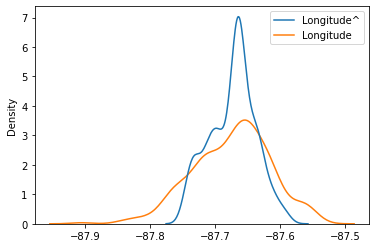

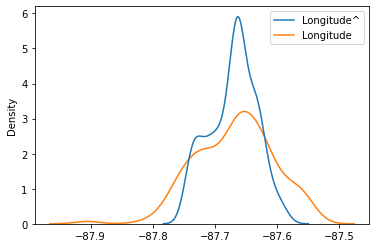

In [262]:
plt.figure()
sns.kdeplot(data=Sn[['Longitude^']+vart2])
plt.figure()
sns.kdeplot(data=St[['Longitude^']+vart2])

### RC

In [242]:
hp=dict(alpha=np.arange(0.1,3,0.1))
modelo = Ridge()
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [243]:
grid.fit(Sn[best],Sn[vart2[0]])

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [244]:
grid.best_params_

{'alpha': 0.5}

In [245]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=0.5)

In [246]:
modelo.fit(Sn[best],Sn[vart2[0]])

Ridge(alpha=0.5)

#### Validación

In [247]:
Sn['Longitude^'] = modelo.predict(Sn[best])
St['Longitude^'] = modelo.predict(St[best])

In [248]:
print(mean_absolute_error(y_pred=Sn['Longitude^'],y_true=Sn[vart2[0]]))
print(mean_absolute_error(y_pred=St['Longitude^'],y_true=St[vart2[0]]))

0.03929210832143653
0.041288908280374535


In [249]:
print(r2_score(y_pred=Sn['Longitude^'],y_true=Sn[vart2[0]]))
print(r2_score(y_pred=St['Longitude^'],y_true=St[vart2[0]]))

0.34557628297239995
0.35558897112818233


<AxesSubplot:ylabel='Density'>

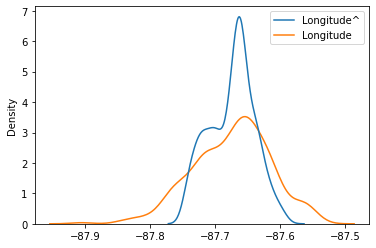

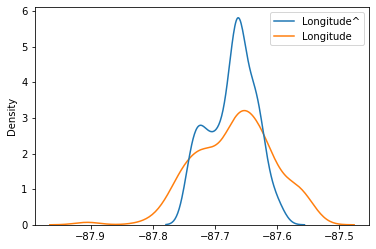

In [250]:
plt.figure()
sns.kdeplot(data=Sn[['Longitude^']+vart2])
plt.figure()
sns.kdeplot(data=St[['Longitude^']+vart2])

# Visualización de predicciones

In [263]:
Sn.head()

,ID,Ward,Community Area,Beat,District,Latitude,Longitude,Latitude^,Longitude^
0,9064064,0.551020,0.342105,0.422442,0.416667,41.874558,-87.693718,41.866979,-87.673789
1,7556706,0.142857,0.552632,0.125000,0.125000,41.758139,-87.574905,41.791457,-87.629509
2,1338504,0.448980,0.407895,0.586221,0.583333,41.888347,-87.755214,41.866868,-87.687167
3,10671475,0.020408,0.407895,0.004950,0.000000,41.868080,-87.632268,41.802800,-87.605669
4,9561108,0.469388,0.328947,0.421205,0.416667,41.875921,-87.727959,41.866896,-87.669016


In [264]:
St.head()

,ID,Ward,Community Area,Beat,District,Latitude,Longitude,Latitude^,Longitude^
0,9643341,0.326531,0.894737,0.210396,0.208333,41.754048,-87.635600,41.743161,-87.658566
1,6816073,0.244898,0.907895,0.298267,0.291667,41.748526,-87.725944,41.745885,-87.662821
2,9745949,0.673469,0.631579,0.875413,0.875000,41.695630,-87.635239,41.859206,-87.735627
3,8248580,0.061224,0.500000,0.830446,0.041667,41.809041,-87.601690,41.811501,-87.594045
4,10608272,0.081633,0.526316,0.090759,0.083333,41.791178,-87.585414,41.790870,-87.621010


In [265]:
St[['Latitude^']+vart1].iplot(kind='lines')

In [266]:
St[['Longitude^']+vart2].iplot(kind='lines')

In [302]:
Predicciones = St[um+['Latitude^']+['Longitude^']].merge(df[um+['Date']+
            ['Primary Type']+['Description']+
            ['Arrest']],on=um,how='inner')

In [303]:
Predicciones['Ubicacion'] = [', '.join([str(round(a,6)),str(round(b,6))]) for a,b in zip(Predicciones['Latitude^'], Predicciones['Longitude^'])]

In [304]:
Pred = Predicciones.drop({'Latitude^','Longitude^'},axis=1)

In [306]:
Pred['Date'] = pd.to_datetime(Pred['Date'])

In [307]:
Pred.head()

,ID,Date,Primary Type,Description,Arrest,Ubicacion
0,9643341,2014-06-06 18:45:00,BATTERY,DOMESTIC BATTERY SIMPLE,False,"41.743161, -87.658566"
1,6816073,2009-03-19 10:27:00,BURGLARY,ATTEMPT FORCIBLE ENTRY,True,"41.745885, -87.662821"
2,9745949,2014-08-20 21:00:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,True,"41.859206, -87.735627"
3,8248580,2011-09-05 20:55:00,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,True,"41.811501, -87.594045"
4,10608272,2016-07-22 23:18:00,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,True,"41.79087, -87.62101"


In [3]:
Pred = pd.read_csv('Chicago_preds.csv',sep=';')
Pred.head()

,Unnamed: 0,ID,Date,Primary Type,Description,Arrest,Ubicacion
0,0,9643341,2014-06-06 18:45:00,BATTERY,DOMESTIC BATTERY SIMPLE,False,"41.743161, -87.658566"
1,1,6816073,2009-03-19 10:27:00,BURGLARY,ATTEMPT FORCIBLE ENTRY,True,"41.745885, -87.662821"
2,2,9745949,2014-08-20 21:00:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,True,"41.859206, -87.735627"
3,3,8248580,2011-09-05 20:55:00,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,True,"41.811501, -87.594045"
4,4,10608272,2016-07-22 23:18:00,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,True,"41.79087, -87.62101"


In [4]:
from geopy.geocoders import Nominatim

In [123]:
geolocator = Nominatim(user_agent="Googlemaps")

In [124]:
Pred['Direccion'] = list(map(lambda v:geolocator.reverse(v).address,Pred['Ubicacion']))

In [127]:
Pred.head()

,ID,Date,Primary Type,Description,Arrest,Ubicacion,Direccion
0,9643341,2014-06-06 18:45:00,BATTERY,DOMESTIC BATTERY SIMPLE,False,"41.743161, -87.658566","1348-1356, West 83rd Street, South Englewood, ..."
1,6816073,2009-03-19 10:27:00,BURGLARY,ATTEMPT FORCIBLE ENTRY,True,"41.745885, -87.662821","8127, South Ashland Avenue, South Englewood, A..."
2,9745949,2014-08-20 21:00:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,True,"41.859206, -87.735627","1545, South Kenneth Avenue, North Lawndale, Ch..."
3,8248580,2011-09-05 20:55:00,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,True,"41.811501, -87.594045","4611, South Lake Park Avenue, Indian Village, ..."
4,10608272,2016-07-22 23:18:00,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,True,"41.79087, -87.62101","5700-5702, South Indiana Avenue, Washington Pa..."


In [129]:
Pred.to_csv('Chicago_preds.csv',sep=',',index=False,columns=Pred.columns)